# ABS Quarterly Consumer Price Index 6401

## Python set-up

In [1]:
# system imports
import sys

# analytic imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# local imports
from abs_data_capture import (
    find_id,
    get_ABS_meta_and_data,
    get_fs_constants,
    get_plot_constants,
    get_meta_constants,
)
from plotting import (
    clear_chart_dir,
    finalise_plot,
    line_plot,
    plot_growth_finalise,
    set_chart_dir,
)

# pandas display settings
pd.options.display.max_rows = None
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 100

# display charts in this notebook
SHOW = False

## Get data from ABS

In [2]:
catalogue_id = "6401"
source, CHART_DIR, META_DATA = get_fs_constants(catalogue_id)
abs_dict = get_ABS_meta_and_data(catalogue_id)
if abs_dict is None:
    sys.exit(-1)

meta = abs_dict[META_DATA]
RECENT, plot_times, plot_tags = get_plot_constants(meta)
did_col, id_col, table_col, type_col, unit_col = get_meta_constants()

Found URL for a ZIP file on ABS web page
We need to download this file from the ABS ...
Saving ABS download to cache.
Extracting DataFrames from the zip-file ...


## Plot

### Manage chart directory

In [3]:
clear_chart_dir(CHART_DIR)
set_chart_dir(CHART_DIR)
plt.style.use("fivethirtyeight")

### Useful plot elements

In [4]:
annual_target = {
    "axhspan": {
        "ymin": 2,
        "ymax": 3,
        "color": "#dddddd",
        "label": "2-3% annual inflation target",
        "zorder": -1,
    }
}

quarterly_target = {
    "axhline": {
        "y": (pow(1.025, 0.25) - 1) * 100,
        "linestyle": "dashed",
        "linewidth": 0.75,
        "color": "darkred",
        "label": "Quarterly growth consistent with 2.5% annual inflation",
    }
}

### Headline CPI for Australia - Annual+Quarterly

In [5]:
def annualise_percentages(series: pd.Series, periods: int = 4) -> pd.Series:
    """Annualise a growth rate for a period."""

    s = series / 100.0
    annual = (((1 + s) ** periods) - 1) * 100
    return annual

In [6]:
# Used for pattern matching retrieval

quarterly_phrase = "Percentage Change from Previous Period"
annual_phrase = "Percentage Change from Corresponding Quarter of Previous Year"
aus_phrase = "Australia"

In [7]:
table = "2"
data_t2 = abs_dict[table]
series_type = "Original"
title = "All groups CPI ;  Australia"

# get data identifiers
label = "All groups CPI "
a_id, _ = find_id(
    meta,
    {
        table: table_col,
        series_type: type_col,
        annual_phrase: did_col,
        label: did_col,
        aus_phrase: did_col,
    },
)
q_id, _ = find_id(
    meta,
    {
        table: table_col,
        series_type: type_col,
        quarterly_phrase: did_col,
        label: did_col,
        aus_phrase: did_col,
    },
)

# plot
for plot_from, plot_tag in zip(plot_times, plot_tags):
    p_plot_from = (
        None if plot_from is None else pd.Period(plot_from, freq=data_t2.index.freq)
    )
    plot_growth_finalise(
        data_t2[a_id],
        data_t2[q_id],
        from_=p_plot_from,
        title=f"Australia: {label}",
        tag=plot_tag,
        **annual_target,
        **quarterly_target,
        rfooter=f"{source} {table}",
        lfooter=f"{series_type.capitalize()} series",
        show=SHOW,
    )
    
comparative = pd.DataFrame((data_t2[a_id], annualise_percentages(data_t2[q_id])), 
                           index=("Annual rate", "Quarterly annualised rate")).T
line_plot(
    comparative,
    starts=plot_times,
    title=f"Australia: {label}",
    ylabel="Per cent growth",
    y0=True,
    tags="annual-v-annualised",
    **annual_target,
    rfooter=f"{source} {table}",
    lfooter=f"{series_type.capitalize()} series",
    show=SHOW,
)

### Historical - last four quarters

In [8]:
# Latest annual
data_t2[a_id].tail()

Series ID
2022Q3    7.3
2022Q4    7.8
2023Q1    7.0
2023Q2    6.0
2023Q3    5.4
Freq: Q-DEC, Name: A2325847F, dtype: float64

In [9]:
# Latest qty
data_t2[q_id].tail()

Series ID
2022Q3    1.8
2022Q4    1.9
2023Q1    1.4
2023Q2    0.8
2023Q3    1.2
Freq: Q-DEC, Name: A2325850V, dtype: float64

### Predictive annual for next quarter

In [10]:
def predictive_cpi(series: pd.Series, outlook: float = None) -> float:
    """Predict annual CPI, given historical three quarters,
    and an outlook quarterly figure for the future.
    Arguments:
    series - pd.Series with PeriodIndex of quarterly CPI increases
             in percentage points
    output - float | None - prospective CPI increase in percentage
             points. if None, use the average of the past three
             quarters.
    Returns float - predicted annual CPI increase given outlook."""

    if outlook is None:
        outlook = series[-3:].mean()
    base = (series[-3:] / 100) + 1
    base[base.index[-1] + 1] = (outlook) / 100 + 1
    return (base.cumprod()[-1] - 1) * 100

In [11]:
# predictive assuming growth next quarter 
# is the average of the last three quarters
round(predictive_cpi(data_t2[q_id]), 1)

/var/folders/96/8bhlz_x975z93glbxq_2_yqr0000gn/T/ipykernel_3274/493881757.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (base.cumprod()[-1] - 1) * 100


4.6

In [12]:
# predictive assuming OUTLOOK percent growth next quarter
# given most annual inflation is largely baked in already.
print("Annual CPI growth expectations")
OUTLOOK = np.arange(-0.5, 3.1, 0.25)
for outlook in OUTLOOK:
    annual = round(predictive_cpi(data_t2[q_id], outlook), 1)
    annualised = round((pow((outlook / 100) + 1, 4) - 1) * 100, 1)
    print(f"{annual}% pa if next Q is {outlook}% [ie {annualised}% annualised]")

Annual CPI growth expectations
2.9% pa if next Q is -0.5% [ie -2.0% annualised]
3.2% pa if next Q is -0.25% [ie -1.0% annualised]
3.4% pa if next Q is 0.0% [ie 0.0% annualised]
3.7% pa if next Q is 0.25% [ie 1.0% annualised]
4.0% pa if next Q is 0.5% [ie 2.0% annualised]
4.2% pa if next Q is 0.75% [ie 3.0% annualised]
4.5% pa if next Q is 1.0% [ie 4.1% annualised]
4.7% pa if next Q is 1.25% [ie 5.1% annualised]
5.0% pa if next Q is 1.5% [ie 6.1% annualised]
5.2% pa if next Q is 1.75% [ie 7.2% annualised]
5.5% pa if next Q is 2.0% [ie 8.2% annualised]
5.8% pa if next Q is 2.25% [ie 9.3% annualised]
6.0% pa if next Q is 2.5% [ie 10.4% annualised]
6.3% pa if next Q is 2.75% [ie 11.5% annualised]
6.5% pa if next Q is 3.0% [ie 12.6% annualised]


/var/folders/96/8bhlz_x975z93glbxq_2_yqr0000gn/T/ipykernel_3274/493881757.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (base.cumprod()[-1] - 1) * 100


### Trimmed Mean / Weighted Median - Seas Adj - Annual+Quarterly

In [13]:
if False:
    meta[meta.Table == "8"]

In [14]:
table = "8"
data_t8 = abs_dict[table]
series_type = "Seasonally Adjusted"

for label, series_type in [
    ("Trimmed Mean", "Seasonally Adjusted" ),
    ("Weighted Median", "Seasonally Adjusted" ),
    ("All groups CPI", "Seasonally Adjusted" ),
    ("All groups CPI excluding 'volatile items'", "Original"),
    ("All groups CPI excluding food and energy", "Original"),
    ("All groups, goods component", "Original"),
    ("All groups, services component", "Original"),
    ("Tradables", "Original"),    
    ("Non-tradables", "Original"),
]:
    #series_type = "Seasonally Adjusted" if "excluding" not in label else "Original"

    a_id, _ = find_id(
        meta,
        {
            table: table_col,
            series_type: type_col,
            annual_phrase: did_col,
            label: did_col,
        },
    )
    q_id, _ = find_id(
        meta,
        {
            table: table_col,
            series_type: type_col,
            quarterly_phrase: did_col,
            label: did_col,
        },
    )

    title = f"CPI Australia: {label}"

    comparative = pd.DataFrame((data_t8[a_id], 
                                annualise_percentages(data_t8[q_id])), 
                               index=("Annual rate", 
                                      "Quarterly annualised rate")).T
    line_plot(
        comparative,
        starts=plot_times[1:],
            title=title,
            ylabel="Per cent growth",
            y0=True,
            tags="annual-v-annualised",
            **annual_target,
            rfooter=f"{source} {table}",
            lfooter=f"{series_type.capitalize()} series",
            show=SHOW,
        )
    
    for plot_from, plot_tag in zip(plot_times, plot_tags):
        p_plot_from = (
            None if plot_from is None else pd.Period(plot_from, freq=data_t8.index.freq)
        )
        plot_growth_finalise(
            data_t8[a_id],
            data_t8[q_id],
            from_=p_plot_from,
            title=title,
            **annual_target,
            **quarterly_target,
            tag=f'-{series_type.replace(" ", "-")}{plot_tag}',
            rfooter=f"{source} {table}",
            lfooter=series_type,
            show=SHOW,
        )



### Inflation over the long run ...

"... the target for monetary policy in Australia is to achieve an inflation rate of 2–3 per cent, on average, over time."

In [15]:
def annualise_percentages(series: pd.Series, periods: int = 4) -> pd.Series:
    """Annualise a growth rate for a period."""

    s = series / 100.0
    annual = (((1 + s) ** periods) - 1) * 100
    return annual

In [16]:
table = "8"
data_t8 = abs_dict[table].copy()
series_type = "Seasonally Adjusted"

for label in (
    # 'Trimmed Mean',
    "All groups CPI",
):
    q_id, _ = find_id(
        meta,
        {
            table: table_col,
            series_type: type_col,
            quarterly_phrase: did_col,
            label: did_col,
        },
    )
    series = data_t8[q_id].dropna()

    # Averages - different starting points
    a_frame = pd.DataFrame()
    for start in [
        "2005-01-01",
        "2010-01-01",
        "2015-01-01",
        "2020-01-01",
    ]:
        start_period = pd.Period(start, freq="Q")
        a_frame[f"Starting: {start_period}"] = series[
            series.index >= start_period
        ].apply(annualise_percentages)
    a_frame = a_frame.cumsum() / a_frame.notna().cumsum()

    line_plot(
        a_frame,
        title=f"CPI Australia: {label} - Cumulative Average",
        ylabel="Per cent",
        **annual_target,
        rfooter=f"{source} {table}",
        lfooter=f"{series_type}. "
        "Cumulative average of quarterly change annualised; various starting points.",
        # show=True,
    )

    # Rolling averages of different lengths
    r_frame = pd.DataFrame()
    for years in (3, 5, 7, 10):  # years
        QTR_PER_YEAR = 4
        r_frame[f"{years}-Year rolling ave."] = (
            series.rolling(years * QTR_PER_YEAR).mean().apply(annualise_percentages)
        )
    line_plot(
        r_frame,
        title=f"CPI Australia: {label} - Rolling Averages",
        ylabel="Per cent",
        **annual_target,
        rfooter=f"{source} {table}",
        lfooter=f"{series_type}. Rolling average of quarterly change annualised; various-periods.",
        show=SHOW,
    )

### Analytical annual series

In [17]:
table = "8"
data = abs_dict[table]
stem = "Percentage Change from Corresponding Quarter of Previous Year ;  "
post = " ;  Australia ;"
groups = [
    ["Tradables", "Non-tradables"],
    ["Original", "Seasonally Adjusted"],
    ["Goods", "Services"],
    ["Trimmed Mean", "Weighted Median"],
]

# manage long/ugly names
replacements = {
    "Goods": "All groups, goods component",
    "Services": "All groups, services component",
    "Original": "All groups CPI",
    "Seasonally Adjusted": "All groups CPI, seasonally adjusted",
}

for dataset in groups:
    idents = []
    for title in dataset:
        if title in replacements:
            title = replacements[title]
        description = f"{stem}{title}{post}"
        series_type = (
            "Seasonally Adjusted"
            if "season" in title or "Trimmed" in title or "Weighted" in title
            else "Original"
        )
        search = {
            table: table_col,
            description: did_col,
            series_type: type_col,
        }
        ident, units = find_id(meta, search)
        idents.append(ident)

    for start, tag in zip(plot_times, plot_tags):
        df = (
            data[data.index >= pd.Period(start, freq=data.index.freq)]
            if start
            else data
        )
        pair = df[idents]
        pair = pair.dropna(how="all", axis=0)
        pair.columns = dataset
        ax = pair.plot(lw=2, color=["blue", "darkorange"])
        finalise_plot(
            ax,
            title=f'CPI Australia: {", ".join(dataset)}',
            ylabel=units,
            tag=tag,
            **annual_target,
            legend={"loc": "best", "fontsize": "x-small"},
            rfooter=f"{source} {table}",
            lfooter="Per cent change from same quarter in previous year",
            show=SHOW,
        )

### Expenditure groups, sub-groups and classes

#### Map of groups, sub-groups, classses

In [18]:
expenditure_groups = {
    "Food and non-alcoholic beverages",
    "Alcohol and tobacco",
    "Clothing and footwear",
    "Housing",
    "Furnishings, household equipment and services",
    "Health",
    "Transport",
    "Communication",
    "Recreation and culture",
    "Education",
    "Insurance and financial services",
}

expenditure_sub_groups = {
    "Bread and cereal products",
    "Meat and seafoods",
    "Dairy and related products",
    "Fruit and vegetables",
    "Food products n.e.c.",
    "Non-alcoholic beverages",
    "Meals out and take away foods",
    "Alcoholic beverages",
    "Tobacco",
    "Garments",
    "Footwear",
    "Accessories and clothing services",
    "Rents",
    "New dwelling purchase by owner-occupiers",
    "Other housing",
    "Utilities",
    "Furniture and furnishings",
    "Household textiles",
    "Household appliances, utensils and tools",
    "Non-durable household products",
    "Domestic and household services",
    "Medical products, appliances and equipment",
    "Medical, dental and hospital services",
    "Private motoring",
    "Urban transport fares",
    "Communication",
    "Audio, visual and computing equipment and services",
    "Newspapers, books and stationery",
    "Holiday travel and accommodation",
    "Other recreation, sport and culture",
    "Education",
    "Insurance",
    "Financial services",
}

expenditure_classes = {
    "Bread",
    "Cakes and biscuits",
    "Breakfast cereals",
    "Other cereal products",
    "Beef and veal",
    "Pork",
    "Lamb and goat",
    "Poultry",
    "Other meats",
    "Fish and other seafood",
    "Milk",
    "Cheese",
    "Ice cream and other dairy products",
    "Fruit",
    "Vegetables",
    "Eggs",
    "Jams, honey and spreads",
    "Food additives and condiments",
    "Oils and fats",
    "Snacks and confectionery",
    "Other food products n.e.c.",
    "Coffee, tea and cocoa",
    "Waters, soft drinks and juices",
    "Restaurant meals",
    "Take away and fast foods",
    "Spirits",
    "Wine",
    "Beer",
    "Tobacco",
    "Garments for men",
    "Garments for women",
    "Garments for infants and children",
    "Footwear for men",
    "Footwear for women",
    "Footwear for infants and children",
    "Accessories",
    "Cleaning, repair and hire of clothing and footwear",
    "Rents",
    "New dwelling purchase by owner-occupiers",
    "Maintenance and repair of the dwelling",
    "Property rates and charges",
    "Water and sewerage",
    "Electricity",
    "Gas and other household fuels",
    "Furniture",
    "Carpets and other floor coverings",
    "Household textiles",
    "Major household appliances",
    "Small electric household appliances",
    "Glassware, tableware and household utensils",
    "Tools and equipment for house and garden",
    "Cleaning and maintenance products",
    "Personal care products",
    "Other non-durable household products",
    "Child care",
    "Hairdressing and personal grooming services",
    "Other household services",
    "Pharmaceutical products",
    "Therapeutic appliances and equipment",
    "Medical and hospital services",
    "Dental services",
    "Motor vehicles",
    "Spare parts and accessories for motor vehicles",
    "Automotive fuel",
    "Maintenance and repair of motor vehicles",
    "Other services in respect of motor vehicles",
    "Urban transport fares",
    "Postal services",
    "Telecommunication equipment and services",
    "Audio, visual and computing equipment",
    "Audio, visual and computing media and services",
    "Books",
    "Newspapers, magazines and stationery",
    "Domestic holiday travel and accommodation",
    "International holiday travel and accommodation",
    "Equipment for sports, camping and open-air recreation",
    "Games, toys and hobbies",
    "Pets and related products",
    "Veterinary and other services for pets",
    "Sports participation",
    "Other recreational, sporting and cultural services",
    "Preschool and primary education",
    "Secondary education",
    "Tertiary education",
    "Insurance",
    "Deposit and loan facilities (direct charges)",
    "Other financial services",
}

# sanity checks on above maps
print(
    f"Check count mapped items: {len(expenditure_groups) + len(expenditure_sub_groups) + len(expenditure_classes)}"
)

# identify any missing
table = "7"
data = abs_dict[table].copy()
index_select = "Index Numbers"
items = meta[
    (meta["Table"] == table)
    & (meta["Data Item Description"].str.contains(index_select))
]
items = (
    items["Data Item Description"]
    .str.replace(";  Australia ;", "")
    .str.replace("Index Numbers ;", "")
    .str.strip()
).to_list()
print(f"Check count ABS columns: {len(items)} - should be one more than above")

print("Missing ...")  # should be only "all groups cpi"
_ = [
    print(i)
    for i in items
    if i not in expenditure_classes
    and i not in expenditure_sub_groups
    and i not in expenditure_groups
]
_ = [print(g) for g in expenditure_groups if g not in items]
_ = [print(sg) for sg in expenditure_sub_groups if sg not in items]
_ = [print(c) for c in expenditure_classes if c not in items]

Check count mapped items: 131
Check count ABS columns: 132 - should be one more than above
Missing ...
All groups CPI


#### Plot annual and quarterly growth by expenditure group

In [19]:
def get_cpi_growth_elements(
    level: str = "class", mode: str = "annual"
) -> pd.DataFrame | None:
    # set-up
    table = "7"

    # sanity checks
    modes = ("annual", "quarterly")
    if mode not in modes:
        print(f"Warning: mode should be one of {modes}")
        return None
    levels = ("group", "sub-group", "class")
    if level not in levels:
        print(f"Warning: level should be one of {levels}")
        return None

    # compile DataFrame of required data items
    at_level = {
        "class": expenditure_classes,
        "sub-group": expenditure_sub_groups,
        "group": expenditure_groups,
    }[level]
    at_mode = {"annual": annual_phrase, "quarterly": quarterly_phrase}[mode]
    table = "7"

    data = pd.DataFrame()
    for cluster in at_level:
        id_selector = {
            table: table_col,
            at_mode: did_col,
            cluster: did_col,
        }

        id, _ = find_id(meta, search_terms=id_selector, validate_unique=False)
        data[cluster] = abs_dict[table][id]

    return data

In [20]:
table = "7"

for level in "group", "sub-group":
    figsize = (9, 10) if level == "sub-group" else (9, 4.5)
    for mode in "annual", "quarterly":
        data = get_cpi_growth_elements(level=level, mode=mode)
        quarter = str(pd.Period(data.index[-1], freq="Q")).replace("Q", " Q")
        data = data.iloc[-1].sort_values()

        ax = data.plot.barh()
        title = f"{mode.capitalize()} Growth by\nCPI {level.capitalize()}"
        finalise_plot(
            ax,
            title=title,
            xlabel="Per cent",
            rfooter=f"{source} {table}",
            lfooter=f"Australia. {quarter}. Original series.",
            figsize=figsize,
            show=SHOW,
        )

#### Plot top/bottom growing expenditure classes

In [21]:
TOP_KEEP = 20
table = "7"

for mode in "annual", "quarterly":
    data = get_cpi_growth_elements(level="class", mode=mode)
    quarter = str(pd.Period(data.index[-1], freq="Q")).replace("Q", " Q")

    for tag in ("top", "last"):
        subset = (
            data.iloc[-1].sort_values(ascending=True)[-TOP_KEEP:]
            if tag == "top"
            else data.iloc[-1].sort_values(ascending=True)[:TOP_KEEP]
        )

        ax = subset.plot.barh()
        title = (
            f"{mode.capitalize()} Growth by CPI\nExpenditure Class - {tag} {TOP_KEEP}"
        )
        finalise_plot(
            ax,
            title=title,
            tag=tag,
            xlabel="Per cent",
            rfooter=f"{source} {table}",
            lfooter=f"Australia. {quarter}. Note: there are {len(expenditure_classes)} expenditure classes",
            figsize=(9, 6),
            show=SHOW,
        )

#### Breadth of inflation across CPI classes

In [22]:
# set-up
table = "7"
A_THRESHOLD = 3.0  # per cent - upper policy target
# compound quarterisation ...
Q_THRESHHOLD = ((((A_THRESHOLD / 100) + 1) ** 0.25) - 1) * 100

for modality in "annual", "quarterly":
    # get the data
    data = get_cpi_growth_elements(level="class", mode=modality)

    # calculate breadth
    thresh = A_THRESHOLD if modality == "annual" else Q_THRESHHOLD
    rounding = 1 if modality == "annual" else 3
    inflating_count = (data > thresh).sum(axis=1, skipna=True)
    total = data.notna().sum(axis=1)
    breadth = inflating_count / total * 100

    # plot results
    ax = breadth.plot(lw=2.5)
    finalise_plot(
        ax,
        title=f"CPI exp. classes with {modality} "
        f"price growth > {round(thresh, rounding)}%",
        ylabel="Per cent",
        rfooter=f"{source} {table}",
        lfooter="Australia. Original series. "
        "CPI expenditure classes only. "
        f"Endpoint: {breadth.iloc[-1]:0.2f}% of CPI expenditure classes. ",
        show=SHOW,
    )

### Tails in CPI expenditure classes

In [23]:
# set-up
table = "7"
BASE_START = data.index[-1].year - 10

In [24]:
for mode in "annual", "quarterly":
    data = get_cpi_growth_elements(level="class", mode=mode)
    base = data[
        (data.index.year >= BASE_START)
    ]

    ax = base.T.quantile(q=[0.1, 0.5, 0.9], numeric_only=True).T.plot(lw=2.5)
    ax.legend(title='Quantiles', loc='upper left')
    finalise_plot(
        ax,
        title=f"{mode.capitalize()} Growth by CPI Expenditure Classes",
        tag="quartile",
        ylabel="Per cent",
        y0=True,
        rfooter=f"{source} {table}",
        lfooter="Australia. Original series. "
            "CPI expenditure classes only. ",
        show=SHOW,
    )


In [25]:
def distro_plot(base: pd.DataFrame, bounds=None, **kwargs) -> None:
    """Produce distributional plots for the data.
     Assume **kwargs includes title, rfooter and lfooter."""
    
    bounds = 15 if bounds is None else bounds
    adj = base.median(axis=1).max()
    min_plot, max_plot = -bounds + adj, bounds + adj
    min_data, max_data = base.min().min(), base.max().max()
    if min_data < min_plot or max_data > max_plot:
        min_plot, max_plot = max(min_plot, min_data), min(max_plot, max_data)
        kwargs["lfooter"] += "Larger outliers not plotted. "
    PADDING = 0.025
    adj = (max_plot - min_plot) * PADDING
    ylim = min_plot - adj, max_plot + adj

    ax = base.T.boxplot(rot=22.5)
    finalise_plot(
        ax,
        tag="box",
        ylabel="Per cent",
        ylim=ylim,
        show=SHOW,
        **kwargs,
    )

    ax = sns.violinplot(base.T, cut=0, linewidth=1, rot=30)
    [tick.set_rotation(22.5) for tick in ax.get_xticklabels()]
    finalise_plot(
        ax,
        tag="violin",
        ylabel="Per cent",
        ylim=ylim,
        show=SHOW,
        **kwargs,
    )

AttributeError: PolyCollection.set() got an unexpected keyword argument 'rot'

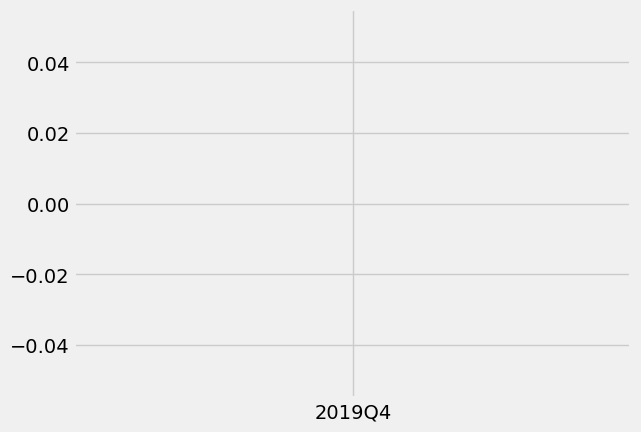

In [26]:
# recent N Quarters

N = 16
mode = "quarterly"
data = get_cpi_growth_elements(level="class", mode=mode)
base = data.iloc[-N:]
title = f"Distribution of {mode.capitalize()} Growth by CPI Exp. Class"
rfooter=f"{source} {table}"
lfooter="Australia. Original series. CPI expenditure classes only. "

distro_plot(base, title=title, rfooter=rfooter, lfooter=lfooter, pre_tag="recent",
            **quarterly_target, legend={"loc": "best", "fontsize": "x-small"})

In [ ]:
# comparisons with same quarter in previous years

for mode in "annual", "quarterly":
    data = get_cpi_growth_elements(level="class", mode=mode)
    current_qtr = data.index[-1].quarter
    base = data[
        (data.index.year >= BASE_START)
        & (data.index.quarter == current_qtr)
    ]
    title = f"Distribution of {mode.capitalize()} Growth by CPI Exp. Class"
    rfooter = f"{source} {table}"
    lfooter = "Australia. Original series. CPI expenditure classes only. "
    bounds = 25 if mode == "annual" else 15
    
    distro_plot(base, bounds=bounds, title=title, rfooter=rfooter, lfooter=lfooter, 
                pre_tag="by-year", y0=True)
    

## Finished

In [ ]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

In [ ]:
print("Finished")